In [1]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5  # Scaling factor for stability

        # Linear projections for Q, K, V
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        # Learnable kernel function fθ
        self.learnable_kernel = nn.Sequential(
            nn.Linear(dim_head, dim_head),
            nn.GELU(),
            nn.Linear(dim_head, dim_head)
        )

        # Output projection
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        # Compute Q, K, V
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        # Apply learnable kernel function fθ
        q = self.learnable_kernel(q)
        k = self.learnable_kernel(k)

        # Compute attention using kernelized linear attention
        # Step 1: Compute Key-Value projection
        kv = torch.einsum('bhnd,bhmd->bhnm', k, v)

        # Step 2: Compute Query and projected KV
        out = torch.einsum('bhnd,bhnm->bhmd', q, kv)

        # Reshape and project back
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout)),  # 调用改造后的 Attention
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x  # Add residual connection
            x = ff(x) + x    # Add residual connection
        return x


class ViTPR(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # Patch embedding
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim),
        )

        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        # Transformer with Performer-ReLU Attention
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)  # Convert image to patches
        b, n, _ = x.shape

        # Add CLS token
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        # Pass through Transformer
        x = self.transformer(x)

        # Pooling
        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import os
import csv
import torch.nn.functional as F

# 超参数
lr = 1e-3
batch_size = 64
num_epochs = 20  # MNIST 训练收敛快，可减少 epoch
patch_size = 7   # 28x28 的图像中，7x7 的 patch
image_size = 28  # MNIST 图像为 28x28
num_classes = 10
dim = 128
depth = 6
heads = 8
mlp_dim = 512
dropout = 0.3
emb_dropout = 0.3
channels = 1     # MNIST 图像为单通道
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据集
print("==> Preparing MNIST dataset...")
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # MNIST 单通道图像归一化
])

transform_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 初始化 ViTPR 模型
print("==> Building Vision Transformer model...")
net = ViTPR(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim,
    depth=depth,
    heads=heads,
    mlp_dim=mlp_dim,
    dropout=dropout,
    emb_dropout=emb_dropout,
    channels=channels  # 单通道
).to(device)


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# 定义训练函数
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print(f"Train Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
              f"Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}%")

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s.")
    return epoch_time, 100. * correct / total

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    inference_time = time.time() - start_time
    acc = 100. * correct / total
    print(f"Test Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {test_loss/len(test_loader):.4f} | Acc: {acc:.2f}% | Inference Time: {inference_time:.2f}s")
    return acc, inference_time

==> Preparing MNIST dataset...
==> Building Vision Transformer model...


In [3]:
# 保存模型的最佳状态
checkpoint_path = "./Performer ReLu_lr_1e-3_dropout_0.3_bonus_MNIST_checkpoint.pth"
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0
    best_acc = 0
# 创建或打开 CSV 文件
csv_file = "Performer ReLu_lr_1e-3_dropout_0.3_bonus_MNIST.csv"
write_header = not os.path.exists(csv_file)

with open(csv_file, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["Epoch", "Train Time (s)", "Inference Time (s)", "Accuracy (%)"])

    # 开始训练
    train_times = []
    inference_times = []
    accuracies = []

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_time, train_acc = train(epoch)
        train_times.append(train_time)

        acc, inference_time = test(epoch)
        accuracies.append(acc)
        inference_times.append(inference_time)

        scheduler.step()

        if acc > best_acc:
            print("Saving best model...")
            state = {
                'model': net.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            torch.save(state, checkpoint_path)
            best_acc = acc

        writer.writerow([epoch+1, train_time, inference_time, acc])
        f.flush()
        print(f"Epoch {epoch+1} results saved to CSV.")

Loading checkpoint from ./Performer ReLu_lr_1e-3_dropout_0.3_bonus_MNIST_checkpoint.pth...
Epoch 3/20


C:\Users\ZBLibra\AppData\Local\Temp\ipykernel_13036\2419452021.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Train Epoch [3/20] Batch [1/938] Loss: 0.4390 | Acc: 84.38%
Train Epoch [3/20] Batch [2/938] Loss: 0.5687 | Acc: 83.59%
Train Epoch [3/20] Batch [3/938] Loss: 0.7931 | Acc: 80.73%
Train Epoch [3/20] Batch [4/938] Loss: 0.5287 | Acc: 80.08%
Train Epoch [3/20] Batch [5/938] Loss: 0.5784 | Acc: 80.00%
Train Epoch [3/20] Batch [6/938] Loss: 0.4201 | Acc: 80.99%
Train Epoch [3/20] Batch [7/938] Loss: 0.6437 | Acc: 80.13%
Train Epoch [3/20] Batch [8/938] Loss: 0.6148 | Acc: 80.66%
Train Epoch [3/20] Batch [9/938] Loss: 0.6676 | Acc: 79.86%
Train Epoch [3/20] Batch [10/938] Loss: 0.3439 | Acc: 80.47%
Train Epoch [3/20] Batch [11/938] Loss: 0.4362 | Acc: 81.11%
Train Epoch [3/20] Batch [12/938] Loss: 0.6057 | Acc: 81.12%
Train Epoch [3/20] Batch [13/938] Loss: 0.6279 | Acc: 80.29%
Train Epoch [3/20] Batch [14/938] Loss: 0.3502 | Acc: 80.92%
Train Epoch [3/20] Batch [15/938] Loss: 0.4309 | Acc: 81.35%
Train Epoch [3/20] Batch [16/938] Loss: 0.2732 | Acc: 82.03%
Train Epoch [3/20] Batch [17/938]

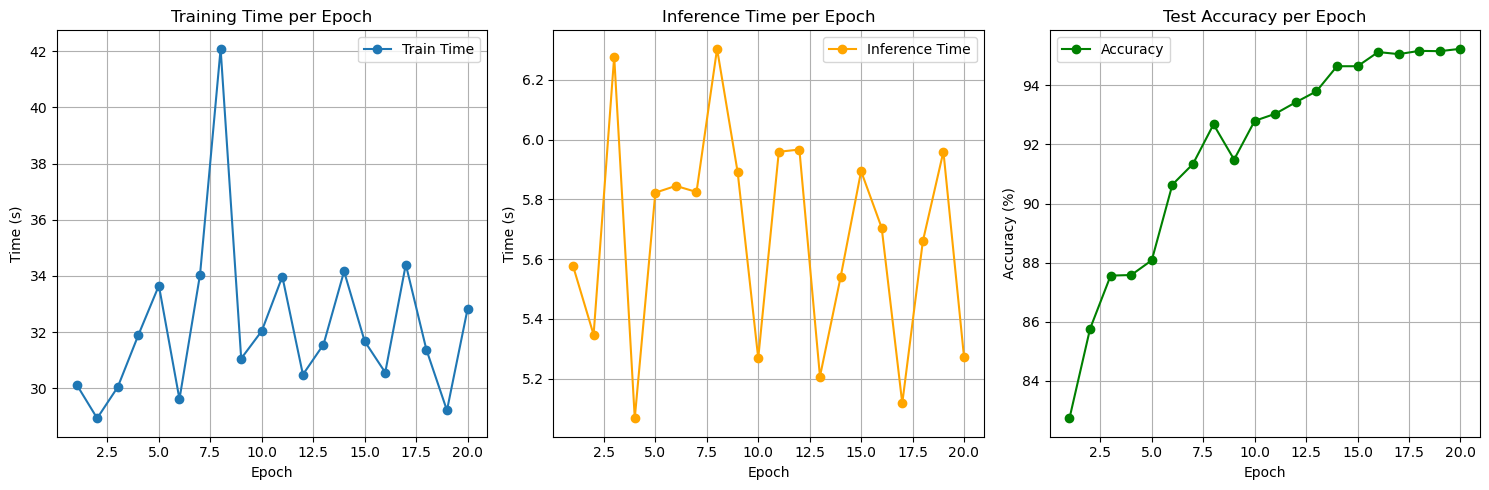

'Performer ReLu_lr_1e-3_dropout_0.3_bonus_MNIST.png'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'Performer ReLu_lr_1e-3_dropout_0.3_bonus_MNIST.csv'
data = pd.read_csv(file_path)

# Extract data for plotting
epochs = data['Epoch']
train_times = data['Train Time (s)']
inference_times = data['Inference Time (s)']
accuracies = data['Accuracy (%)']

# Plot the data
plt.figure(figsize=(15, 5))

# Training time per epoch
plt.subplot(1, 3, 1)
plt.plot(epochs, train_times, marker='o', label='Train Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Training Time per Epoch")
plt.grid(True)
plt.legend()

# Inference time per epoch
plt.subplot(1, 3, 2)
plt.plot(epochs, inference_times, marker='o', color='orange', label='Inference Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Inference Time per Epoch")
plt.grid(True)
plt.legend()

# Test accuracy per epoch
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracies, marker='o', color='green', label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.grid(True)
plt.legend()

# Finalize and save the figure
plt.tight_layout()
output_path = "Performer ReLu_lr_1e-3_dropout_0.3_bonus_MNIST.png"
plt.savefig(output_path)
plt.show()

output_path